Check Python version

In [1]:
!python --version

Python 3.9.16


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
file_name = 'Returns_short_interest_data_train.csv'

In [4]:
dataset = pd.read_csv(file_name)

In [5]:
dataset.shape

(788, 15)

In [6]:
dataset.columns

Index(['date', 'log_dp', 'log_dy', 'log_ep', 'log_de', 'bm', 'ntis', 'tbl',
       'lty', 'ltr', 'tml', 'dfy', 'dfr', 'infl_lag', 'target'],
      dtype='object')

In [7]:
dataset.head()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target
0,1937-05-01,-2.999429,-2.999429,-2.648946,-0.350483,0.489382,0.028278,0.0041,0.0282,0.0053,0.0241,0.0151,-0.0013,-2.999429,-0.006041
1,1937-06-01,-2.908721,-2.908721,-2.577364,-0.331357,0.504961,0.031266,0.0036,0.0285,-0.0018,0.0249,0.0165,0.0071,-2.908721,-0.054103
2,1937-07-01,-3.034560,-3.034560,-2.660885,-0.373675,0.464649,0.027225,0.0028,0.0277,0.0138,0.0249,0.0166,-0.0099,-3.034560,0.098758
3,1937-08-01,-3.006598,-3.006598,-2.589993,-0.416605,0.481935,0.031064,0.0029,0.0286,-0.0104,0.0257,0.0168,0.0087,-3.006598,-0.051425
4,1937-09-01,-2.883131,-2.883131,-2.422915,-0.460216,0.553147,0.035847,0.0031,0.0284,0.0045,0.0253,0.0188,-0.0020,-2.883131,-0.139868


In [8]:
dataset.tail()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target
783,2002-08-01,-4.054990,-4.054990,-3.454868,-0.600122,0.284412,0.025483,0.0162,0.0510,0.0464,0.0348,0.0121,-0.0012,-4.054990,0.005711
784,2002-09-01,-3.943471,-3.943471,-3.301014,-0.642457,0.324555,0.029393,0.0163,0.0480,0.0417,0.0317,0.0125,-0.0087,-3.943471,-0.110377
785,2002-10-01,-4.020567,-4.020567,-3.411479,-0.609089,0.293437,0.025778,0.0158,0.0508,-0.0294,0.0350,0.0141,0.0054,-4.020567,0.087282
786,2002-11-01,-4.070296,-4.070296,-3.495323,-0.574973,0.276975,0.023009,0.0123,0.0521,-0.0122,0.0398,0.0131,0.0252,-4.070296,0.057994
787,2002-12-01,-4.002328,-4.002328,-3.462264,-0.540064,0.295386,0.025838,0.0119,0.0484,0.0507,0.0365,0.0124,-0.0146,-4.002328,-0.059826


Define the required time and target columns

In [9]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [10]:
# dataset[target_col] = dataset[target_col].astype(float)

In [11]:
# dataset.head()

Split dataset into train and test sets

In [12]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

In [13]:
train_df['date'].min(), train_df['date'].max(), \
test_df['date'].min(), test_df['date'].max()

('1937-05-01', '1989-10-01', '1989-11-01', '2002-12-01')

Plot graph

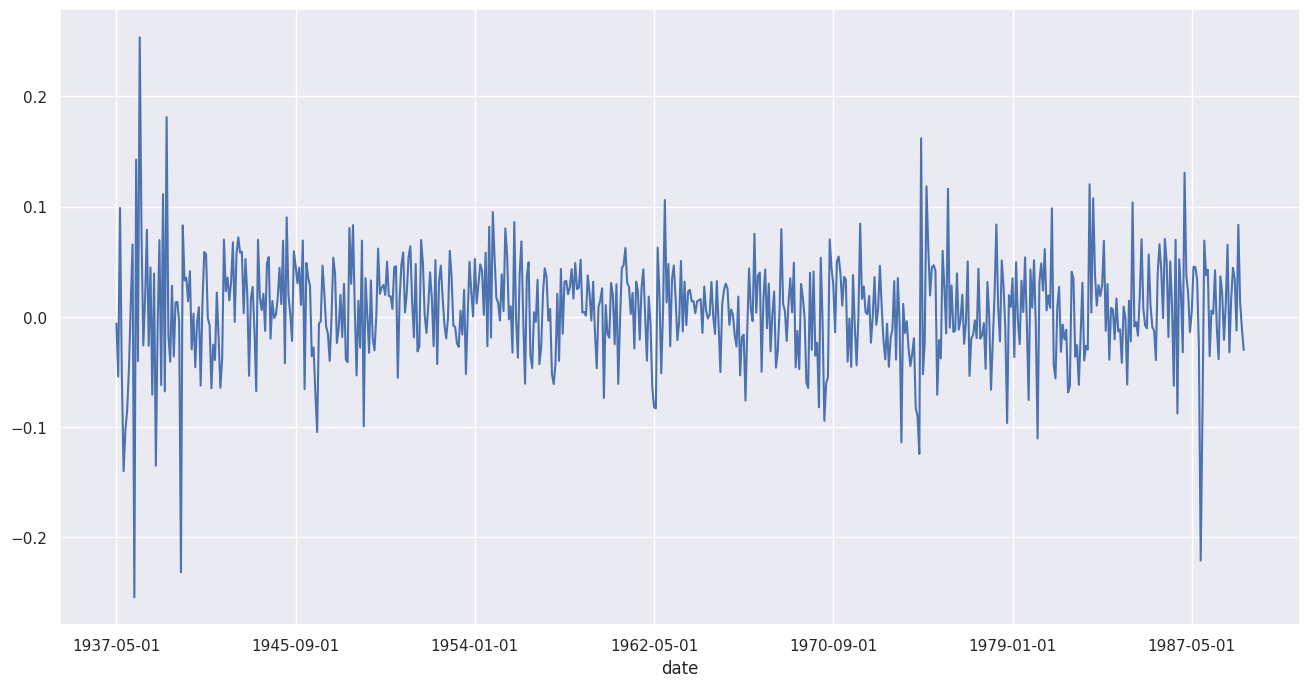

In [14]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [15]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [16]:
train_data[:2]

[['1937-05-01',
  -2.9994291354353173,
  -2.9994291354353173,
  -2.648946161744506,
  -0.3504829736908111,
  0.4893824051284986,
  0.0282780631029591,
  0.0040999999999999,
  0.0282,
  0.0053,
  0.0241,
  0.0150999999999999,
  -0.0013,
  -2.9994291354353173,
  -0.0060406666666666],
 ['1937-06-01',
  -2.908720896564361,
  -2.908720896564361,
  -2.5773637606099187,
  -0.3313571359544425,
  0.5049610205527995,
  0.0312661665365891,
  0.0036,
  0.0285,
  -0.0018,
  0.0249,
  0.0165,
  0.0071,
  -2.908720896564361,
  -0.054103]]

Custom Model Request (optional)

In [17]:
# Default model request
model_request = {
    'type': 'meta_lr',  # 'meta_wa'
    'scorers': ['smape', 'mape'],
    'params': {
        'preprocessors': [
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            #{'type': 'darts_rnn'},
            {'type': 'darts_lightgbm'},  # TODO: Need to fix use of covariates lags
            {'type': 'darts_autotheta'},
            # {'type': 'darts_autoarima'},
            {'type': 'darts_autoets'},
            # {'type': 'stats_autotheta'},
            # {'type': 'stats_autoarima'},
            # {'type': 'stats_autoets'},
        ],
    },
}

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'param': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [18]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [19]:
with open('url_.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [20]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [21]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [22]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

/home/kevin/anaconda3/envs/test/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil-test.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


CPU times: user 35 ms, sys: 6.1 ms, total: 41.1 ms
Wall time: 4.83 s


In [23]:
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [24]:
train_json_out

{'model': 'AgEBCCZOBwAgTgcAcAMGABgAAABmAwYAKMUAAD+AAGVsaZOMb5Rsb4xJk4xnbl8SY2lygW1uZWFnaWNyXRxhaWJueG5lc2M0lHRwbWFjdG1hS4cNdAJSlP90AOADAB+UlF2FKC6HMv90CAgdqnKv1OstXUOQCJQfaIcNAQIDBB8FBgcICQoLDA2UhgZ9c2+UZWeMbmMNYV9lX2EFlHNsbBhhaGmUc3JhlChsZ3BsZQ9slACUAjEoTv9i4ANk4P///+4AB2IBlGghlEuJ4wT7HzYdY2VlEnRkjG2TE19yX2lBa3BveWlhcriUiQT/S3N0CyQpTQJSTv8oS3QA8cAAAPLgEQAA8+ASAAD04BEAAPXgEgAA9uARAAD34BEAAPjgEgAA+eARAAD64BIAAPvgEQAA/OARAAD94BIAAP7gEQAA/+ARAOEEv+AGAAAB4BEAAALgEgAAA+ARAAAE4BIAAAXgEQAABuARAAAH4BIAAAjgCAAUBXN0Ul1ylJRiTXKUS0uUKCiUS1KU4AT1F5RSJ5SFu7u/mTXTQxf2pUJfu3RoJClLaOAEJAl1aMVoS1JiYJR14BBCDP7++66Jyb4zJPj/Nf7gDEIA7aBCH29vZGV0UpRfXYxylBFybGFnZ2SUYQxzjG4QY3JujGhfH3RfjHRlZZOMZF9yZXJ0kyhkjC5yDXKUjGhhcmVuZGllH05yfTaMlAZ9b3Vtak4AagAoaHghlEuMlE5KlDRqUi6HHzJLYmqGbF+UeG94bnh9ZZRKUktShQCxusPN1uDp8vwFHw4XISozPUZQWWJsdX6HkZqjrbbAydLc5e74AQsUHScwHzpDTFZeaHF7hI2XoKqzvMbO2OHr9P0HEBojLDY+SFFbH2Rtd4CKk5ymr7jBy9Te5/D6Aw0WHygyO0ROV2Bqc32GH4+Yoqu0vsfR2uPt9v8IEhskLjdBSlNdZm95gouVnqixBLrEzdffYIgGGCEqND1HT2CIB

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [25]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [26]:
test_data[:2]

[['1989-11-01',
  -3.455508698863343,
  -3.455508698863343,
  -2.7047031108088846,
  -0.7508055880544587,
  0.3972257017961992,
  -0.0270221107060077,
  0.0769,
  0.0808,
  0.0078,
  0.0038999999999999,
  0.0092,
  -0.0007999999999999,
  -3.455508698863343],
 ['1989-12-01',
  -3.465170131921834,
  -3.465170131921834,
  -2.7377745518509062,
  -0.727395580070928,
  0.3904547435711172,
  -0.0123231066872625,
  0.0762999999999999,
  0.0816,
  -0.0006,
  0.0053,
  0.0096,
  0.0012,
  -3.465170131921834]]

Model from Train API

In [27]:
model = train_json_out['model']

Forecast API JSON Payload

In [28]:
api_json = {
    'model': model,
    'data': test_data
}

Build URL (same as train except for the endpoint)

In [29]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [30]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

/home/kevin/anaconda3/envs/test/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil-test.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


CPU times: user 18.1 ms, sys: 2.71 ms, total: 20.8 ms
Wall time: 575 ms


In [31]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [32]:
forecast_json_out

{'data': [['1989-10-31T00:00:00', 0.00742354298476606],
  ['1989-11-30T00:00:00', 0.002456677845706385],
  ['1989-12-30T00:00:00', 0.001494691325165107],
  ['1990-01-29T00:00:00', 0.002543700175805786],
  ['1990-02-28T00:00:00', 0.0022794554583955235],
  ['1990-03-30T00:00:00', -0.001202748006521875],
  ['1990-04-29T00:00:00', 0.0075225699794851724],
  ['1990-05-29T00:00:00', 0.004002345660975565],
  ['1990-06-28T00:00:00', 0.0017896142001744093],
  ['1990-07-28T00:00:00', -0.0033755376781020602],
  ['1990-08-27T00:00:00', 0.0008640454201296764],
  ['1990-09-26T00:00:00', 0.0018548402527105352],
  ['1990-10-26T00:00:00', 0.004641795716729382],
  ['1990-11-25T00:00:00', 0.003906860359462791],
  ['1990-12-25T00:00:00', 0.004812163324362763],
  ['1991-01-24T00:00:00', 0.004505890492489966],
  ['1991-02-23T00:00:00', 0.004281505640331709],
  ['1991-03-25T00:00:00', 0.003966400260777337],
  ['1991-04-24T00:00:00', 0.002854926313000223],
  ['1991-05-24T00:00:00', 0.0008034823830968287],
  ['

Combine forecast dates and output

In [33]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [34]:
forecast_df.shape

(158, 2)

In [35]:
forecast_df.columns

Index(['date', 'target'], dtype='object')

In [36]:
forecast_df.head()

,date,target
0,1989-10-31T00:00:00,0.007424
1,1989-11-30T00:00:00,0.002457
2,1989-12-30T00:00:00,0.001495
3,1990-01-29T00:00:00,0.002544
4,1990-02-28T00:00:00,0.002279


In [37]:
forecast_df.tail()

,date,target
153,2002-05-26T00:00:00,0.016083
154,2002-06-25T00:00:00,0.012626
155,2002-07-25T00:00:00,0.003832
156,2002-08-24T00:00:00,0.013638
157,2002-09-23T00:00:00,0.013245


Plot train and forecast side-by-side

/tmp/ipykernel_20663/2998340865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


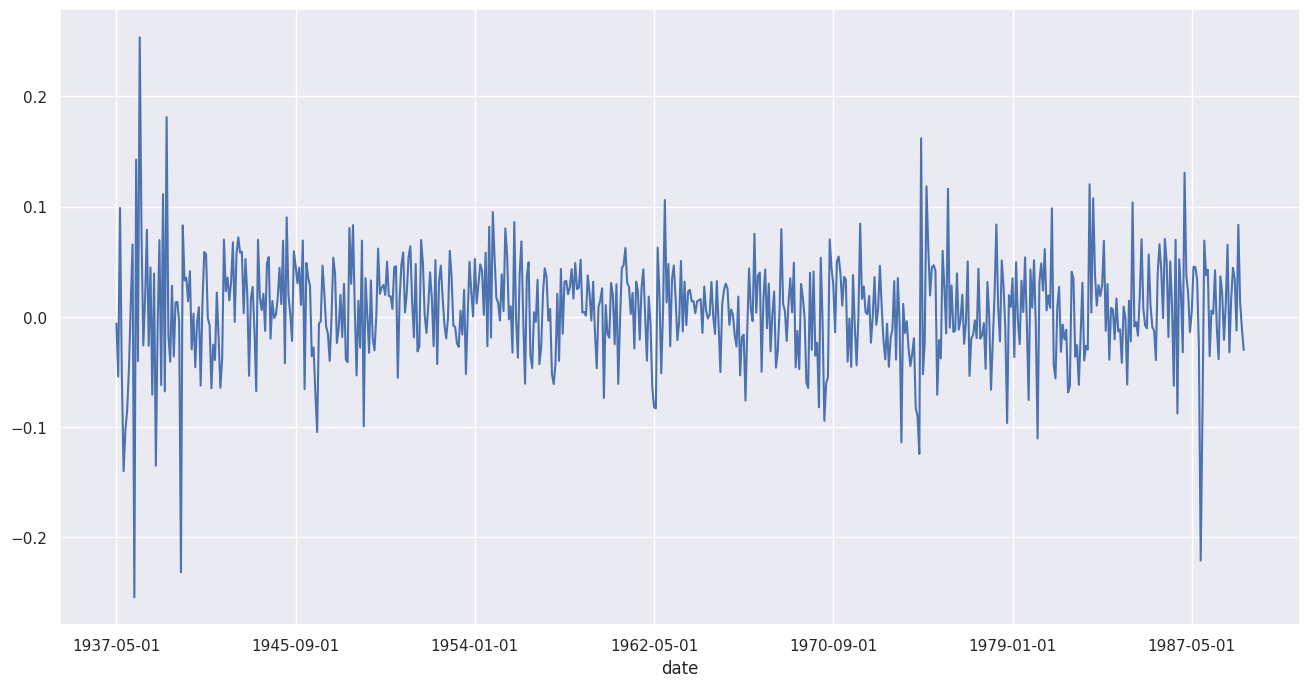

In [38]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

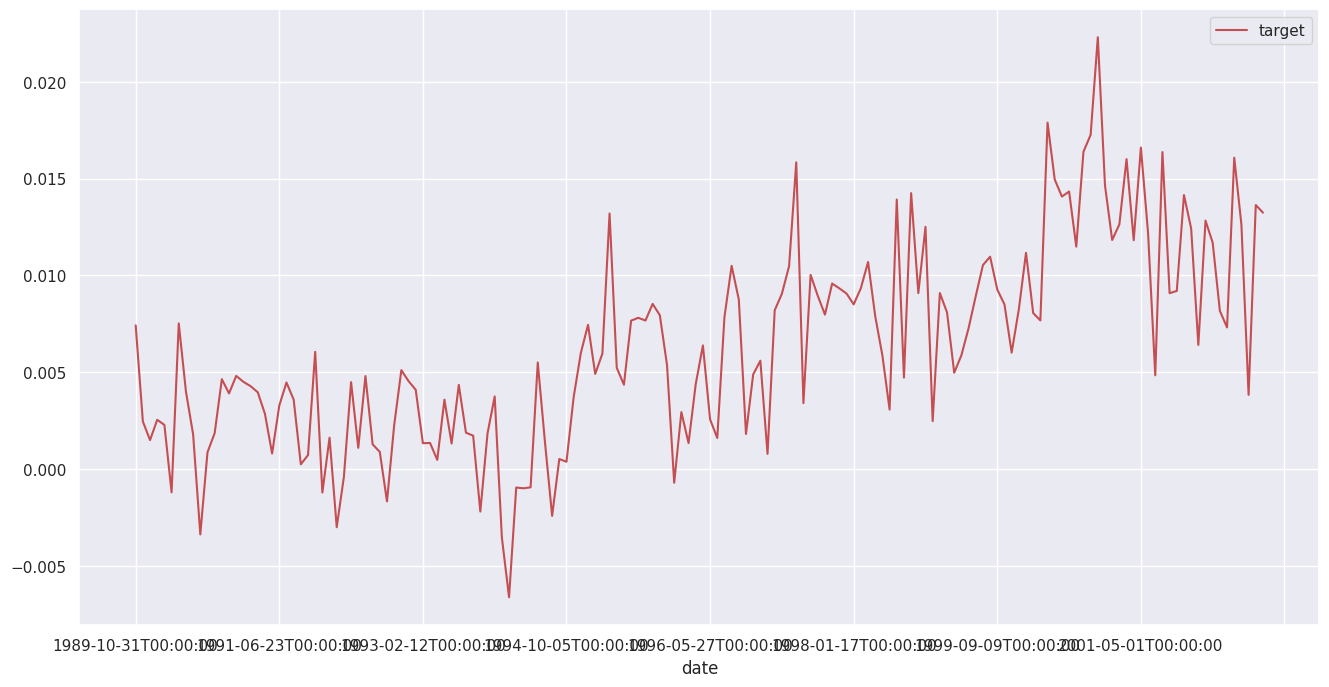

In [39]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [40]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [41]:
df.shape

(788, 16)

In [42]:
df.head()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target,color
0,1937-05-01,-2.999429,-2.999429,-2.648946,-0.350483,0.489382,0.028278,0.0041,0.0282,0.0053,0.0241,0.0151,-0.0013,-2.999429,-0.006041,b
1,1937-06-01,-2.908721,-2.908721,-2.577364,-0.331357,0.504961,0.031266,0.0036,0.0285,-0.0018,0.0249,0.0165,0.0071,-2.908721,-0.054103,b
2,1937-07-01,-3.034560,-3.034560,-2.660885,-0.373675,0.464649,0.027225,0.0028,0.0277,0.0138,0.0249,0.0166,-0.0099,-3.034560,0.098758,b
3,1937-08-01,-3.006598,-3.006598,-2.589993,-0.416605,0.481935,0.031064,0.0029,0.0286,-0.0104,0.0257,0.0168,0.0087,-3.006598,-0.051425,b
4,1937-09-01,-2.883131,-2.883131,-2.422915,-0.460216,0.553147,0.035847,0.0031,0.0284,0.0045,0.0253,0.0188,-0.0020,-2.883131,-0.139868,b


In [43]:
df.tail()

,date,log_dp,log_dy,log_ep,log_de,bm,ntis,tbl,lty,ltr,tml,dfy,dfr,infl_lag,target,color
783,2002-05-26T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016083,r
784,2002-06-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012626,r
785,2002-07-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003832,r
786,2002-08-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013638,r
787,2002-09-23T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013245,r


Plot combined train and test sets with the vertical black line as the cut-off

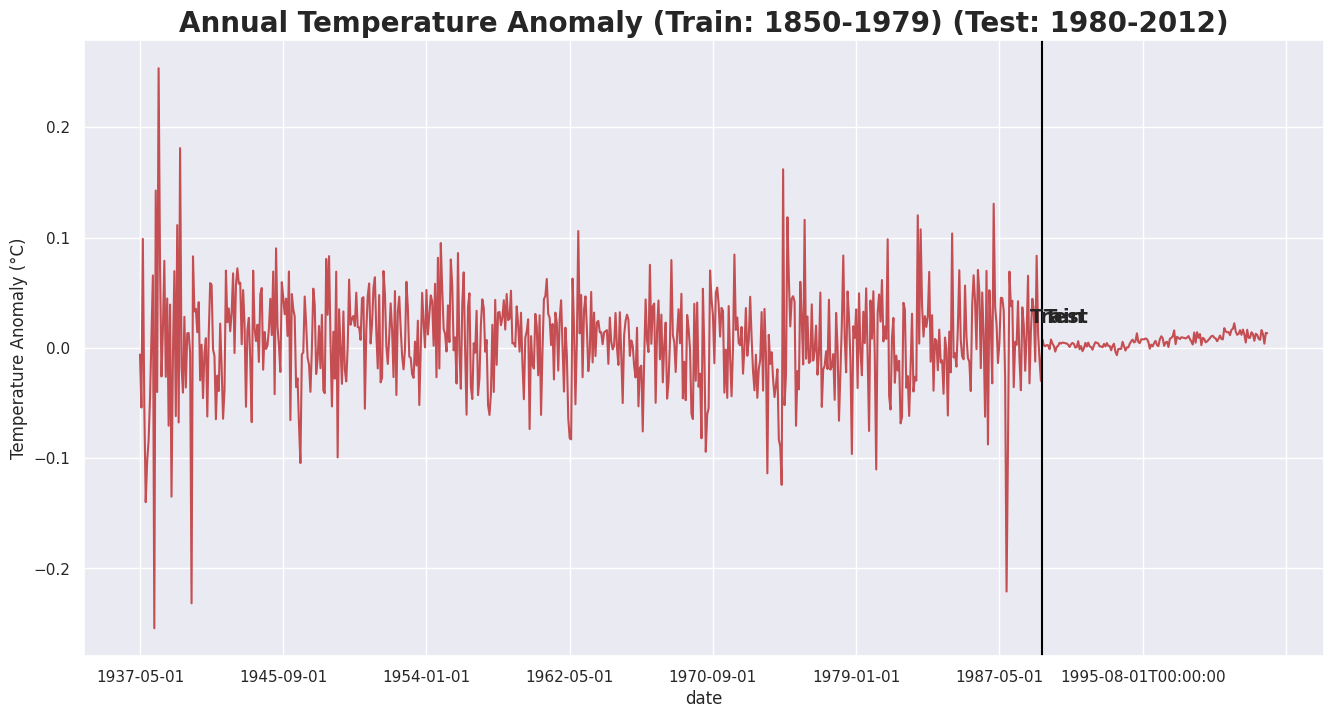

In [44]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Test: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset to compare

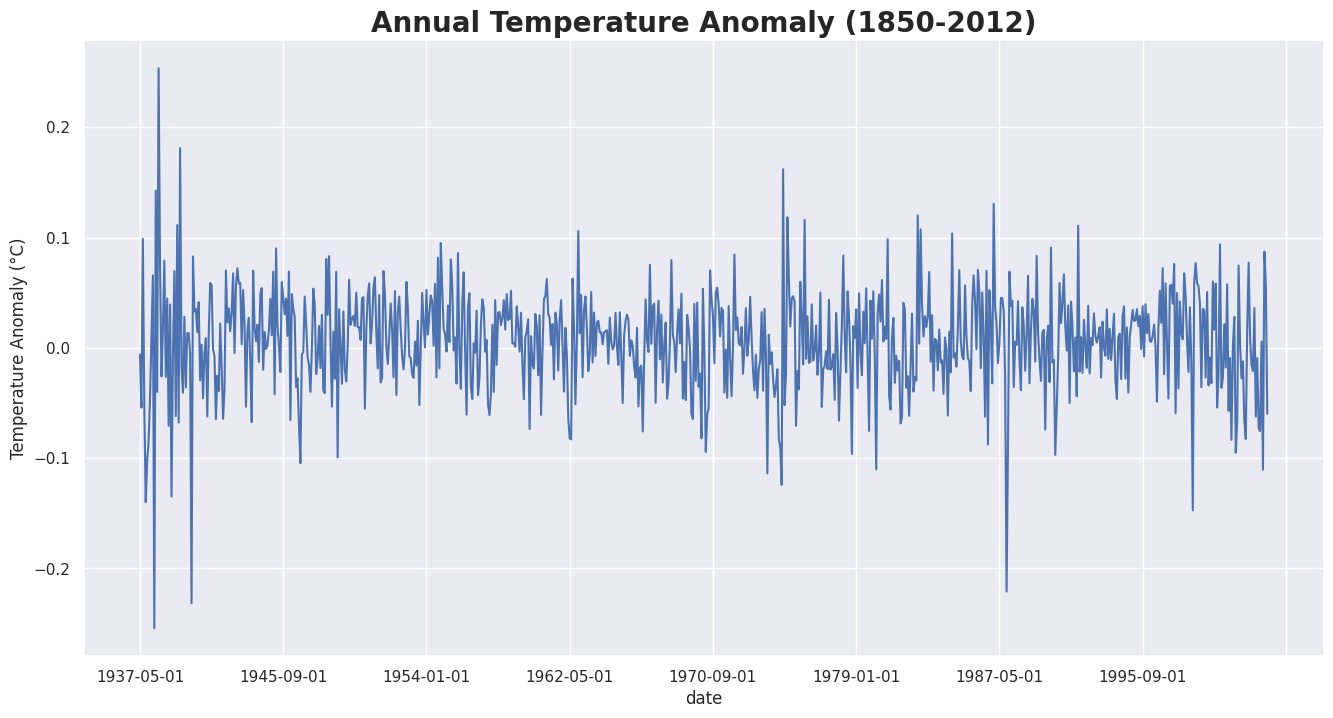

In [45]:
figsize = (16, 8)
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (1850-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset (blue) with SYBIL forecasted values (red)

<Axes: xlabel='date'>

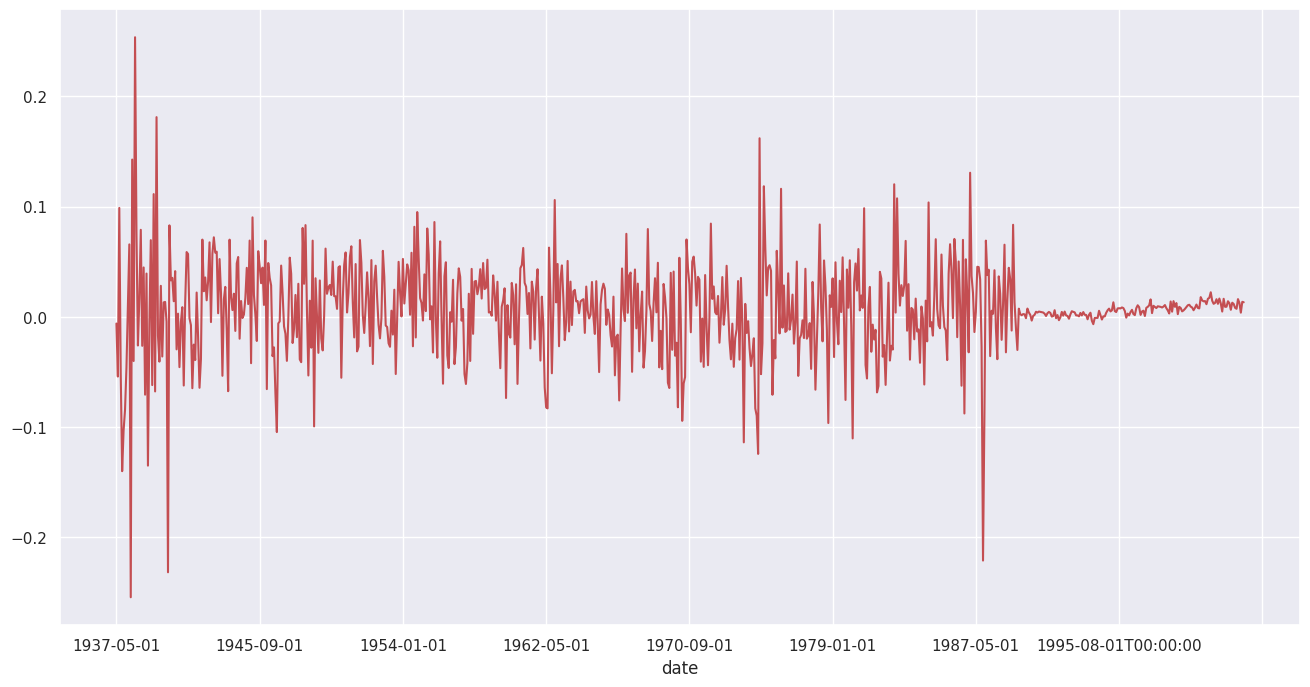

In [46]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')

<Axes: xlabel='date'>

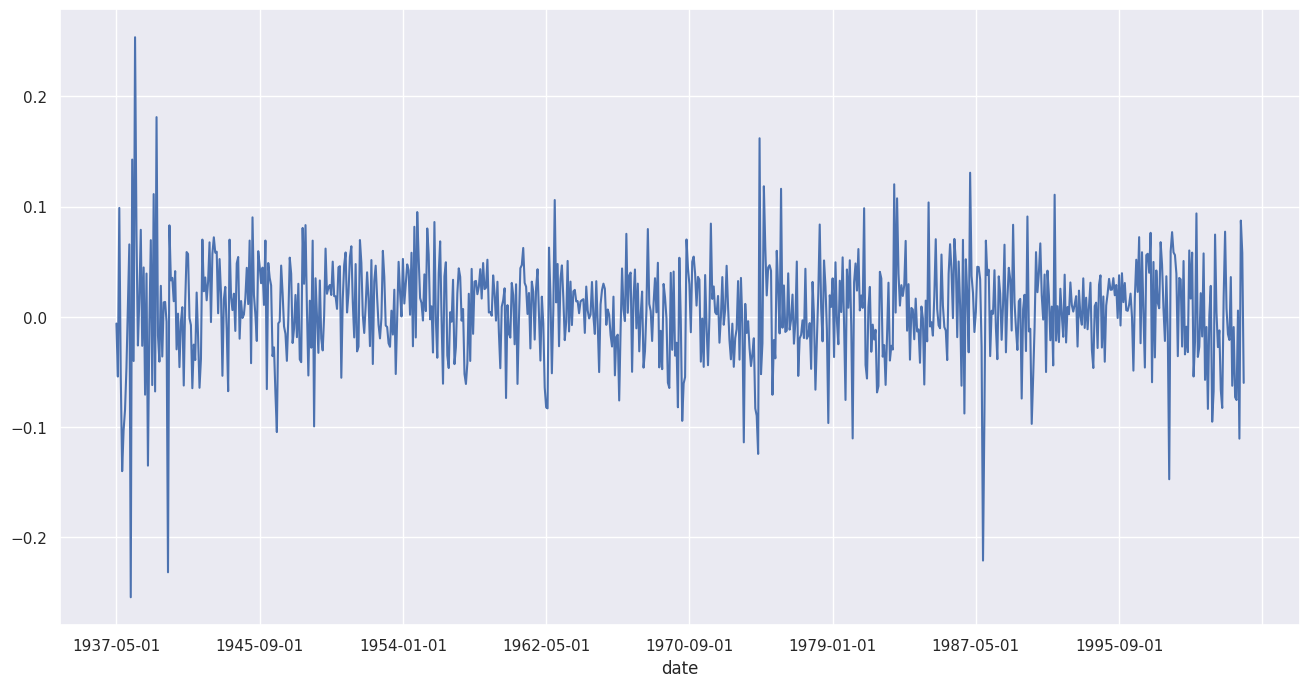

In [47]:
dataset.set_index(time_col)[target_col].plot(figsize=figsize)

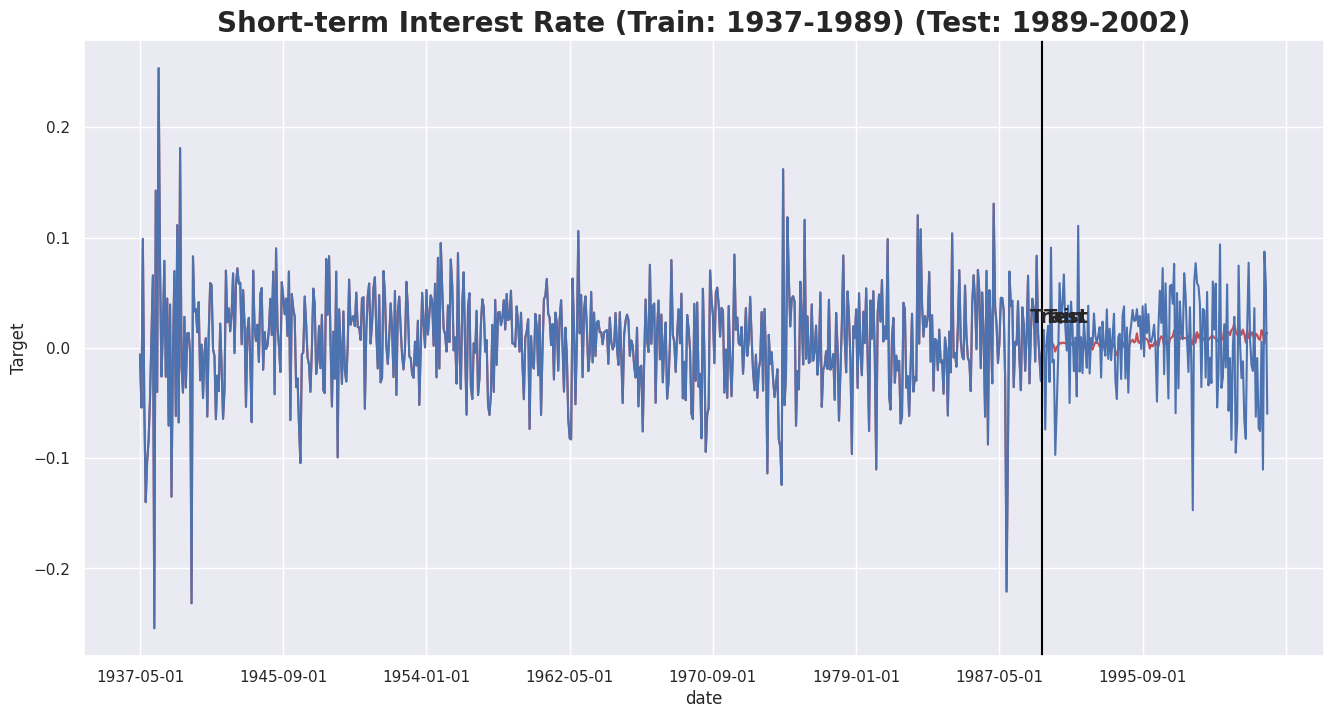

In [48]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
dataset.set_index(time_col)[target_col].plot(figsize=figsize)
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Target')
plt.title(label='Short-term Interest Rate (Train: 1937-1989) (Test: 1989-2002)', fontweight='bold', fontsize=20)
plt.show();